Let's generate and plot a sample function just to visualize the type of function we wish to model

LET'S MAKE A NETWORK OF DANS

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
# from google.colab import drive 
# drive.mount('/content/gdrive')

In [3]:
args = {}
args['n_channels'] = 20
args['dims'] = [1, 5, 10, 5, 1]
args['local_path'] = './HLIR_NB_DATA/'
args['dan_width'] = 70

In [26]:
import copy 
class SIMPLE_DAN(nn.Module):
    # DIMS ARE [n_channels, 50, 100, 50, 1]
    # idx      [         0,  1,   2,  3, 4]
    def __init__(self, n_channels, args):
        super(SIMPLE_DAN, self).__init__()
        self.hidden_dim = args['dan_width']
        self.fc0 = nn.Linear(n_channels, self.hidden_dim)
        self.fc1 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim) 
        self.fc3 = nn.Linear(self.hidden_dim, 1) 
        self.SKIPS = nn.ModuleDict() 

        self.SKIPS['skip 0-2'] = nn.Linear(n_channels,self.hidden_dim)
        self.SKIPS['skip 0-3'] = nn.Linear(n_channels,self.hidden_dim)
        self.SKIPS['skip 0-4'] = nn.Linear(n_channels, 1)

        self.SKIPS['skip 1-3'] = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.SKIPS['skip 1-4'] = nn.Linear(self.hidden_dim, 1)
        
        self.SKIPS['skip 2-4'] = nn.Linear(self.hidden_dim, 1)
    
    def forward(self, x, width): 
        batch_size = x.shape[0]

        x_0_2 = self.SKIPS['skip 0-2'](x.clone())
        x_0_3 = self.SKIPS['skip 0-3'](x.clone())
        x_0_4 = self.SKIPS['skip 0-4'](x.clone())
        x1 = F.tanh(self.fc0(x.clone()))
        
        x_1_3 = self.SKIPS['skip 1-3'](x1.clone())
        x_1_4 = self.SKIPS['skip 1-4'](x1.clone())
        x2 = self.fc1(x1.clone())
        x2 = F.tanh(x2 + x_0_2)
        
        x_2_4 = self.SKIPS['skip 2-4'](x2.clone())
        x3 = self.fc2(x2.clone())
        x3 = F.tanh(x3 + x_0_3 + x_1_3)
        
        x4 = self.fc3(x3.clone())
        x4 = F.tanh(x4 + x_0_4 + x_1_4 + x_2_4)

        x4 = x4.view((len(torch.flatten(x4))//width, width))
        return x4


class NET(nn.Module):
    #  DIMS ARE [1, 50, 100, 50, 1]
    #  idx      [0,  1,   2,  3, 4]
    #  Total params: 193,506
    def __init__(self, n_channels, dims, args=None):
        super(NET, self).__init__()
        torch.manual_seed(42)
        self.VECS = nn.ModuleDict() 
        self.DANS = nn.ModuleDict() 
        self.VECS['fc0'] = nn.Linear(dims[0], dims[1]*n_channels)
        self.VECS['fc1'] = nn.Linear(dims[1], dims[2]*n_channels)
        self.VECS['fc2'] = nn.Linear(dims[2], dims[3]*n_channels)  
        self.VECS['fc3'] = nn.Linear(dims[3], dims[4]*n_channels) 

        # self.VECS['fc0_norm'] = nn.LayerNorm(dims[1]*n_channels)
        # self.VECS['fc1_norm'] = nn.LayerNorm(dims[2]*n_channels)
        # self.VECS['fc2_norm'] = nn.LayerNorm(dims[3]*n_channels)
        # self.VECS['fc3_norm'] = nn.LayerNorm(dims[4]*n_channels)

        self.DANS['L1'] = SIMPLE_DAN(n_channels, args)
        # self.DANS['L2'] = SIMPLE_DAN(n_channels)
        # self.DANS['L3'] = SIMPLE_DAN(n_channels)
        # self.DANS['L4'] = SIMPLE_DAN(n_channels)

        self.VECS['skip 0-2'] = nn.Linear(dims[0], dims[2]*n_channels)
        self.VECS['skip 0-3'] = nn.Linear(dims[0], dims[3]*n_channels)
        self.VECS['skip 0-4'] = nn.Linear(dims[0], dims[4]*n_channels)

        self.VECS['skip 1-3'] = nn.Linear(dims[1], dims[3]*n_channels)
        self.VECS['skip 1-4'] = nn.Linear(dims[1], dims[4]*n_channels)
        
        self.VECS['skip 2-4'] = nn.Linear(dims[2], dims[4]*n_channels)

        torch.nn.init.xavier_uniform_(self.VECS['fc0'].weight)
        torch.nn.init.xavier_uniform_(self.VECS['fc1'].weight)
        torch.nn.init.xavier_uniform_(self.VECS['fc2'].weight)
        torch.nn.init.xavier_uniform_(self.VECS['fc3'].weight)
        torch.nn.init.xavier_uniform_(self.VECS['skip 0-2'].weight)
        torch.nn.init.xavier_uniform_(self.VECS['skip 0-3'].weight)
        torch.nn.init.xavier_uniform_(self.VECS['skip 0-4'].weight)
        torch.nn.init.xavier_uniform_(self.VECS['skip 1-3'].weight)
        torch.nn.init.xavier_uniform_(self.VECS['skip 1-4'].weight)
        torch.nn.init.xavier_uniform_(self.VECS['skip 2-4'].weight)

        self.init_VECS = copy.deepcopy(self.VECS.state_dict())

    def get_DAN_size(self):
        total = 0
        for p in self.DANS['L1'].parameters():
          total += torch.flatten(p).shape[0]
        return total  

    def get_plasticity_ratio(self):
        return round((self.get_model_size()-self.get_DAN_size())/self.get_model_size(), 2)

    def get_model_size(self):
        total = 0
        for p in self.parameters():
          total += torch.flatten(p).shape[0]
        return total 

    def reset_VECS(self, vecs_lr, avg_vecs = None):
        if avg_vecs:
            self.init_VECS = avg_vecs
        self.VECS.load_state_dict(self.init_VECS)
        return torch.optim.Adam(self.VECS.parameters(),  lr=vecs_lr)
    

    def forward(self, x, args): 
        batch_size = args['B']
        num_samples = args['N']
        
        
        

        x_0_2 = self.VECS['skip 0-2'](x.clone())
        x_0_3 = self.VECS['skip 0-3'](x.clone())
        x_0_4 = self.VECS['skip 0-4'](x.clone())
        x0 = F.tanh(self.VECS['fc0'](x.clone()))
        
        ###################################################
        B_x_N = x0.shape[0]
        layer_width = x0.shape[1]//args['n_channels']
        x0 = x0.view(( B_x_N*layer_width, args['n_channels']))
        x1 = self.DANS['L1'](x0, args['dims'][1])

        x_1_3 = self.VECS['skip 1-3'](x1.clone()) 
        x_1_4 = self.VECS['skip 1-4'](x1.clone())
        x2 = self.VECS['fc1'](x1.clone())
        x2 = F.tanh(x2 + x_0_2)

        ##################################################
        B_x_N = x2.shape[0]
        layer_width = x2.shape[1]//args['n_channels']
        x2 = x2.view(( B_x_N*layer_width, args['n_channels']))
        x3 = self.DANS['L1'](x2, args['dims'][2])
        
        x_2_4 = self.VECS['skip 2-4'](x3.clone())
        x4 = self.VECS['fc2'](x3.clone())
        x4 = F.tanh(x4 + x_0_3 + x_1_3)

        ##################################################
        B_x_N = x4.shape[0]
        layer_width = x4.shape[1]//args['n_channels']
        x4 = x4.view(( B_x_N*layer_width, args['n_channels']))
        x5 = self.DANS['L1'](x4, args['dims'][3])

        x6 = self.VECS['fc3'](x5.clone())
        x6 = F.tanh(x6 + x_0_4 + x_1_4 + x_2_4)

        ##################################################
        B_x_N = x6.shape[0]
        layer_width = x6.shape[1]//args['n_channels']
        x6 = x6.view(( B_x_N*layer_width, args['n_channels']))
        x7 = self.DANS['L1'](x6, args['dims'][4])

        x7 = x7.view((args['B'] , args['N']))*5.0
        return x7




Let's take a look at the type of functions we'll be modeling 

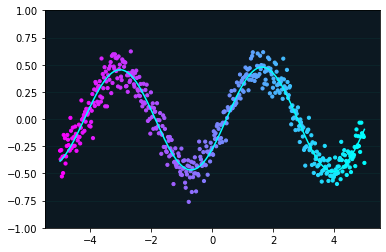

In [6]:
import numpy as np
import matplotlib.pyplot as plt

num_tasks = 20
samples_per_task = 5
samples_per_function = 500
t = np.linspace(-5, 5, samples_per_function)
amplitude1 = np.random.uniform(.1, .9)
amplitude2 = np.random.uniform(.1, .9)
phase1 = np.random.uniform(0, np.pi/2)
phase2 = np.random.uniform(0, np.pi/2)

def mixture_of_sines(t, amplitude1, amplitude2, phase1, phase2):
    
    return ((amplitude1 * np.sin((phase1 * t) + np.random.randint(-5,5)) + amplitude2 * np.cos((phase2 * t) + np.random.randint(-5,5)))/2) 
    



y = mixture_of_sines(t, amplitude1, amplitude2, phase1, phase2)
cur_range = max(y)-min(y)
noisy_y = y + np.random.normal(0, cur_range*.1, size=(samples_per_function,))

fig, ax = plt.subplots()
#plt.ylim(-1, 1)
ax.set_ylim(-1, 1)
plt.scatter(t, noisy_y, s=10, c = t, cmap='cool_r')
plt.plot(t, y, c="cyan")
ax.set_axisbelow(True)
ax.grid(True, axis='y', color="#0B262C")
ax.set_facecolor("#0C1821")
ax.tick_params( colors='black')
# plt.axvline(x=-0.6, color='teal', linestyle='--')
# plt.axvline(x=-0.2, color='teal', linestyle='--')
# plt.axvline(x= 0.2, color='teal', linestyle='--')
# plt.axvline(x= 0.6, color='teal', linestyle='--')
plt.show();

Let's sample a batch of such functions

In [7]:
def get_batch_of_functions(batch_size, args):
  func_data = {}
  func_data['batch_y'] = torch.Tensor()
  func_data['batch_X'] = torch.Tensor()
  func_data['y_true'] = torch.Tensor()

  fps = args['func_params']
  
  
  for b in range(batch_size):
    amplitude1 = np.random.uniform(fps['amp_min'], fps['amp_max'])
    amplitude2 = np.random.uniform(fps['amp_min'], fps['amp_max'])
    phase1 = np.random.uniform(fps['phase_min'], fps['phase_max'])
    phase2 = np.random.uniform(fps['phase_min'], fps['phase_max'])
    y = mixture_of_sines(t, amplitude1, amplitude2, phase1, phase2)
    cur_range = max(y)-min(y)
    noisy_y = y + np.random.normal(0, cur_range*.03, size=(samples_per_function,))
    func_data['y_true'] = torch.cat((func_data['y_true'], torch.Tensor(y).unsqueeze(0)), dim=0)
    func_data['batch_y'] = torch.cat((func_data['batch_y'], torch.Tensor(noisy_y).unsqueeze(0)), dim=0)
    func_data['batch_X'] = torch.cat((func_data['batch_X'], torch.Tensor(t).unsqueeze(0)), dim=0)
    
  return func_data

#batch = get_batch_of_functions(5, args)

# B,N = batch['batch_X'].shape # B = batch_size, N = num_samples per function 
# args['B'] = B
# args['N'] = N

Let's see how we can fetch a batch of such functions and pass them through our model 

In [8]:
model = NET(n_channels = args['n_channels'], dims = args['dims'], args=args)
batch['batch_X'] = batch['batch_X'].view((B * N, 1))
out = model(batch['batch_X'], args)
model.get_model_size()

NameError: name 'batch' is not defined

NON-IID SAMPLING FOR CONTINUAL LEARNING
& PLOTTING 

In [ ]:
%%capture
import warnings
warnings.filterwarnings("ignore")

tasks = list(np.arange(num_tasks))

def train_sim(batch, out):
  filenames = []
  time_samples = {}
  time_samples['x'] = np.array([])
  time_samples['y'] = np.array([])
  y = batch['y_true'][0].detach().numpy()
  noisy_y = batch['batch_y'][0].detach().numpy()
  model_preds = out[0].detach().numpy()


  step = 0
  for task in range(num_tasks):
    for i in range(samples_per_task):
      cur_sample = np.random.choice(np.arange(task*int(samples_per_function/num_tasks),(task*int(samples_per_function/num_tasks))+int(samples_per_function/num_tasks)), 5)
      time_samples['x'] = np.concatenate((time_samples['x'], t[cur_sample]))
      time_samples['y'] = np.concatenate((time_samples['y'], noisy_y[cur_sample]))
      fname = args['local_path']+str(step)+".png"
      filenames.append(fname)
      _ = plt.clf()
      fig, ax = plt.subplots(figsize=(7, 4))
      _ = plt.scatter(t, noisy_y, s=10, c = "#353535") # comment this line if you dont wish to plot all noisy data in the background
      _ = plt.ylim(min(noisy_y)-.5, max(noisy_y)+0.5)
      _ = ax.set_ylim(-1, 1)
      _ = plt.plot(t, y, c="cyan", label='y_true')
      _ = ax.set_axisbelow(True)
      _ = ax.grid(True, axis='y', color="#0B262C")
      _ = ax.set_facecolor("#0C1821")
      _ = ax.tick_params( colors='white')
      _ = plt.axvline(x=-0.6, color='teal', linestyle='--')
      _ = plt.axvline(x=-0.2, color='teal', linestyle='--')
      _ = plt.axvline(x= 0.2, color='teal', linestyle='--')
      _ = plt.axvline(x= 0.6, color='teal', linestyle='--')
      _ = plt.scatter(time_samples['x'], time_samples['y'], s=10, c = np.arange(len(time_samples['x'])), cmap='cool_r')
      _ = plt.plot(t, model_preds, c='#F5F904', linewidth=2, label='y_pred')
      leg = plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', facecolor='black')
      for text in leg.get_texts():
        text.set_color("w")
      _ = plt.tight_layout()
      _ = plt.savefig(fname, facecolor='black')
      step += 1 

  return filenames
  
#filenames = train_sim(batch, out)

LET'S MAKE A GIF

Here we can see how the current training distribution evolves over time. 
The cyan color inidicates the samples currently be exposed to the model. 
The magenta color shows data that the model saw long ago, i.e. historical data. 

In [9]:
import imageio
from IPython.display import Image

def make_gif(filenames):
  images = []
  for filename in filenames:
      images.append(imageio.imread(filename))
  mygif = imageio.mimsave(args['local_path']+'movie.gif', images, duration = 0.04)
  Image(open(args['local_path']+'/movie.gif', 'rb').read()) 

#make_gif(filenames)

ALRIGHT LETS DO SOME HYPER-LEARNING

First lets set some parameters and initialize our population of models 

In [91]:
class POPULATION():
  def __init__(self, args):
    self.models = []
    self.vecs_opts = []
    self.dan_opts = []
    self.priors = []
    self.prior_opts = []
    for m in range(args['population size']):
      self.models.append(NET(n_channels = args['n_channels'], dims = args['dims'], args=args))
      self.vecs_opts.append(torch.optim.Adam(self.models[-1].VECS.parameters(),  lr=args['vecs_lr']))
      self.dan_opts.append(torch.optim.Adam(self.models[-1].DANS.parameters(),  lr=args['dans_lr']))

      #self.priors.append(NET(n_channels = args['n_channels'], dims = args['dims']))
    print("total # params: ", self.models[0].get_model_size())
    print("total # DAN params: ", self.models[0].get_DAN_size())
    print("total # DAN params FULL NET:", self.models[0].get_DAN_size()*(sum(args['dims'])-1))
    print("Plasticity Ratio (wrt single DAN): ", self.models[0].get_plasticity_ratio())
    print("Fixed Ratio (wrt single DAN): ", round(1 - self.models[0].get_plasticity_ratio(), 2))
    self.plasticity_ratio = self.models[0].get_plasticity_ratio()
    self.fixed_ratio = 1 - self.models[0].get_plasticity_ratio()
    self.hyper_losses = []

    self.prior = NET(n_channels = args['n_channels'], dims = args['dims'], args=args)
    self.prior.load_state_dict(self.models[0].state_dict())
    self.prior_opt = torch.optim.Adam(self.prior.DANS.parameters(),  lr=args['prior_lr'])

  def update_prior(self, grads, lr):
    self.prior_opt.zero_grad()
    for name, param in self.prior.DANS.named_parameters():
        param.grad = grads[name]
    self.prior_opt.step()
    self.load_prior()

  def load_prior(self):  
    for m in range(args['population size']):
      self.models[m].DANS.load_state_dict(self.prior.DANS.state_dict())
      self.vecs_opts[m] = torch.optim.Adam(self.models[m].VECS.parameters(),  lr=args['vecs_lr'])
      self.dan_opts[m] = torch.optim.Adam(self.models[m].DANS.parameters(),  lr=args['dans_lr'])

  def get_reptile_loss(self, reptile, model):
    total_loss = 0
    for r,m in zip(reptile.DANS.parameters(), model.DANS.parameters()):
      total_loss += F.mse_loss(m,r)
    return total_loss

  def avg_VECS(self):
    vecs = {}
    for idx, m in enumerate(self.models):
        vecs[str(idx)] = m.VECS.state_dict()

    for key in vecs['0']:
      vecs['0'][key] = (vecs['0'][key] + vecs['1'][key] + vecs['2'][key])/3.
    
    for idx, m in enumerate(self.models):
      m.VECS.load_state_dict(vecs['0'])
      self.vecs_opts[idx] = torch.optim.Adam(m.VECS.parameters(),  lr=args['vecs_lr'])
    return vecs['0'] 
    

  def train(self,args):
    batch = args['data']
    filenames = []
    time_samples = {}
    time_samples['x'] = np.array([])
    time_samples['y'] = np.array([])
    num_tasks = args['num_tasks']
    samples_per_task = args['samples_per_task']
    step = 0
    dan_grads = {}
    prior_grads = {}
    population_hyper_loss = 0
   
    for task in range(num_tasks): 
      for i in range(args['samples_per_task']):
        
        step +=1 
        for m_idx, model in enumerate(self.models):
          vecs_grads = {}
          model.to(args['device'])
          y_true = batch['y_true'][m_idx].detach().numpy()
          noisy_y = batch['batch_y'][m_idx].detach().numpy()
          vecs_opt = self.vecs_opts[m_idx]
          if args['sampling procedure'] == 'iid':
            cur_sample = np.random.choice(np.arange(len(t)), 5)
          else:
            cur_sample = np.random.choice(np.arange(task*int(samples_per_function/num_tasks),(task*int(samples_per_function/num_tasks))+int(samples_per_function/num_tasks)), 5)
          x = torch.tensor(t[cur_sample]).unsqueeze(-1).float()
          train_y = torch.tensor(noisy_y[cur_sample]).unsqueeze(-1).float()
          
          B,N = x.shape # B = number of current samples, N = input shape == 1
          args['B'] = B
          args['N'] = N
          for ss in range(args['steps_per_sample']):
            
            vecs_opt.zero_grad()
            out = model(x.to(args['device']), args)
            loss =  F.mse_loss(out, train_y.to(args['device'])) 
            loss.backward()
            if step > 1:
              vecs_opt.step()
          
          # # FOR WARP GRAD
          # for name, param in model.VECS.named_parameters():
          #     vecs_grads[name] = param.grad.clone()
        
        for ss in range(50):
            
          dan_grads = {}
          # # hyper_loss = 0
          for m_idx, model in enumerate(self.models):
            dan_opt = self.dan_opts[m_idx]

            if args['algorithm'] == 'reptile':
              reptile = NET(n_channels = args['n_channels'], dims = args['dims'], args=args)
              reptile.load_state_dict(model.state_dict())
              reptile_opt = torch.optim.Adam(reptile.DANS.parameters(),  lr=args['reptile_lr'])
              reptile.to(args['device'])
              for r_step in range(args['reptile_steps']):
                noisy_y = batch['batch_y'][m_idx].detach().numpy()
                cur_sample = np.random.choice(np.arange(len(t)), args['hyper_batch_size'])
                x = torch.tensor(t[cur_sample]).unsqueeze(-1).float()
                train_y = torch.tensor(noisy_y[cur_sample]).unsqueeze(-1).float()
                args['B'] = args['hyper_batch_size']
                args['N'] = 1
                reptile_opt.zero_grad()
                out = reptile(x.to(args['device']), args)
                reptile_loss = F.mse_loss(out, train_y.to(args['device']))
                if r_step == 0:
                  if task == num_tasks-1 and i == samples_per_task-1:
                    population_hyper_loss += (reptile_loss.item()/(args['population size']))
                reptile_loss.backward()
                reptile_opt.step() 
              loss = self.get_reptile_loss(reptile, model)
            else:
              
              noisy_y = batch['batch_y'][m_idx].detach().numpy()
              cur_sample = np.random.choice(np.arange(len(t)), args['hyper_batch_size'])
              x = torch.tensor(t[cur_sample]).unsqueeze(-1).float()
              train_y = torch.tensor(noisy_y[cur_sample]).unsqueeze(-1).float()
              args['B'] = args['hyper_batch_size']
              args['N'] = 1
              model.to(args['device'])
              
            
              #use this sampling procedure for memory_loss only
              #cur_sample = np.random.choice(np.arange(0,(task*int(samples_per_function/num_tasks))+int(samples_per_function/num_tasks)), args['hyper_batch_size'])
            
              
              out = model(x.to(args['device']), args)

              loss = F.mse_loss(out, train_y.to(args['device']))
              if task == num_tasks-1 and i == samples_per_task-1:
                population_hyper_loss += loss.item()/(args['population size'])
            dan_opt.zero_grad()
            vecs_opt.zero_grad()
            loss.backward()
          
            
            if m_idx == 0:
                for name, param in model.DANS.named_parameters():
                    dan_grads[name] = param.grad.clone().detach()  
                # if task == 0 and i == 0:
                #   for name, param in model.VECS.named_parameters():
                #       prior_grads[name] = param.grad.clone().detach()  
                # else:
                #   for name, param in model.VECS.named_parameters():
                #     prior_grads[name] += param.grad.clone().detach()             
            else:
                for name, param in model.DANS.named_parameters():
                    dan_grads[name] += param.grad.clone().detach()
                # for name, param in model.VECS.named_parameters():
                #     prior_grads[name] += param.grad.clone().detach()
            #dan_opt.step()       
            
            # # FOR WARP-GRAD
            # vecs_opt.zero_grad()
            # for name, param in model.VECS.named_parameters():
            #       param.grad = vecs_grads[name]
            # if step > 0:
            #   vecs_opt.step()  
          # #NOW AVERAGE THE DAN GRADS, AND UPDATE THE DANS IN ALL MODELS. 
          for m_idx, model in enumerate(self.models):
              self.dan_opts[m_idx].zero_grad()
              for name, param in self.models[m_idx].DANS.named_parameters():
                  param.grad = dan_grads[name]/((args['population size']))
              self.dan_opts[m_idx].step()

    
    # self.prior_opt.zero_grad()
    # for name, param in self.prior.DANS.named_parameters():
    #     param.grad = prior_grads[name]/((args['population size'])*args['num_tasks']*args['samples_per_task'])
    # self.prior_opt.step()
    self.hyper_losses.append(population_hyper_loss)

    #avg_vecs = self.avg_VECS()
   
    
    for m_idx, m in enumerate(self.models):
      self.vecs_opts[m_idx] = m.reset_VECS(args['vecs_lr'])  
      
    #self.update_prior(dan_grads, args['prior_lr'])
    
    return self.hyper_losses

  


  def test(self,args):   
    batch = args['data']
    filenames = []
    time_samples = {}
    time_samples['x'] = np.array([])
    time_samples['y'] = np.array([])
    num_tasks = args['num_tasks']
    samples_per_task = args['samples_per_task']
    y_true = batch['y_true'][0].detach().numpy()
    noisy_y = batch['batch_y'][0].detach().numpy()
    
      
    step = 0
    for task in range(num_tasks):
      
      for i in range(args['samples_per_task']):
        
        population_training_loss = 0
        for m_idx, model in enumerate([self.models[0]]):
          model.to(args['device'])
          noisy_y = batch['batch_y'][m_idx].detach().numpy()
          vecs_opt = self.vecs_opts[m_idx]
         
          if args['sampling procedure'] == 'iid':
            cur_sample = np.random.choice(np.arange(len(t)), 5)
          else:
            cur_sample = np.random.choice(np.arange(task*int(samples_per_function/num_tasks),(task*int(samples_per_function/num_tasks))+int(samples_per_function/num_tasks)), 5)
          x = torch.tensor(t[cur_sample]).unsqueeze(-1).float()
          y = torch.tensor(noisy_y[cur_sample]).unsqueeze(-1).float()
          
          
          B,N = x.shape # B = number of current samples, N = input shape == 1
          args['B'] = B
          args['N'] = N
          for ss in range(args['steps_per_sample']):
            vecs_opt.zero_grad()
            out = model(x.to(args['device']), args)
            loss = F.mse_loss(out, y.to(args['device']))
            population_training_loss += loss.item()/args['population size']
            loss.backward()

            if step > 0:
              vecs_opt.step()
           
          all_x = torch.tensor(t).unsqueeze(-1).float()
          args['B'] = all_x.shape[0]
          model_preds = model(all_x.to(args['device']), args).cpu().detach().numpy() #get preds over whole function

          time_samples['x'] = np.concatenate((time_samples['x'], torch.flatten(x)))
          time_samples['y'] = np.concatenate((time_samples['y'], torch.flatten(y)))
          fname = args['local_path']+str(step)+".png"
          filenames.append(fname)
          _ = plt.clf()
          fig, ax = plt.subplots(figsize=(7, 4))
          #_ = plt.scatter(t, noisy_y, s=10, c = "#353535") # comment this line if you dont wish to plot all noisy data in the background
          _ = ax.set_ylim(-1, 1)
          _ = plt.plot(t, y_true, c="cyan", label='y_true')
          _ = ax.set_axisbelow(True)
          _ = ax.grid(True, axis='y', color="#0B262C")
          _ = ax.set_facecolor("#0C1821")
          _ = ax.tick_params( colors='white')
          # _ = plt.axvline(x=-0.6, color='teal', linestyle='--')
          # _ = plt.axvline(x=-0.2, color='teal', linestyle='--')
          # _ = plt.axvline(x= 0.2, color='teal', linestyle='--')
          # _ = plt.axvline(x= 0.6, color='teal', linestyle='--')
          _ = plt.scatter(time_samples['x'], time_samples['y'], s=10, c = np.arange(len(time_samples['x'])), cmap='cool_r')
          _ = plt.plot(t, model_preds, c='#F5F904', linewidth=2, label='y_pred')
          leg = plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', facecolor='black')
          for text in leg.get_texts():
            text.set_color("w")
          _ = plt.tight_layout()
          _ = plt.savefig(fname, facecolor='black')

          
          step += 1 

    for m_idx, m in enumerate(self.models):
      self.vecs_opts[m_idx] = m.reset_VECS(args['vecs_lr']) 
    #self.load_prior()


    make_gif(filenames)
 

In [92]:
"""
THESE WORK DECENTLY...

args['population size'] = 5
args['models'] = []
args['algorithm'] = 'hyper-learning' # ['warp grad', 'hyper-learning', 'reptile']
args['vecs_opts'] = []
args['dan_opts'] = []
args['outer_epochs'] = 200
args['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args['vecs_lr'] = .01
args['dans_lr'] = .01
args['reptile_lr'] = .001
args['reptile_steps'] = 100
args['hyper_batch_size'] = 20
args['num_tasks'] = 2
args['samples_per_task'] = 15
args['samples_per_tasks'] = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5] #[50,50,45,45,40,40,35,35,30,30,25,25,20,20,15,15,10,10,5,5]
args['n_channels'] = 25
args['dan_width'] = 25
args['dims'] = [1, 10, 10, 10, 1]
"""

args['population size'] = 3
args['models'] = []
args['algorithm'] = 'hyper-learning' # ['warp grad', 'hyper-learning', 'reptile', 'full net iid']
args['vecs_opts'] = []
args['dan_opts'] = []
args['outer_epochs'] = 200
args['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args['vecs_lr'] = .01
args['dans_lr'] = .01
args['prior_lr'] = .01
args['reptile_lr'] = .01
args['reptile_steps'] = 10
args['hyper_batch_size'] = 20
args['num_tasks'] = 5
args['sampling procedure'] = 'non-iid task incremental' # ['iid', 'non-iid task incremental',]
args['samples_per_task'] = 10
args['steps_per_sample'] = 1
args['samples_per_tasks'] = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5] #[50,50,45,45,40,40,35,35,30,30,25,25,20,20,15,15,10,10,5,5]
args['n_channels'] = 40
args['dan_width'] = 40
args['dims'] = [1, 10, 10, 10, 1]

In [93]:
args['population'] = POPULATION(args)
args['hyper_epoch'] = 0

total # params:  27004
total # DAN params:  10004
total # DAN params FULL NET: 310124
Plasticity Ratio (wrt single DAN):  0.63
Fixed Ratio (wrt single DAN):  0.37


Now we want to start training our population and visualizing how its going along the way 

In [35]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


In [14]:
def set_func_params(args, mode):
    args['func_params'] = {}
    if mode == "train":
        args['func_params']['amp_min'] = .1
        args['func_params']['amp_max'] = .9
        args['func_params']['phase_min'] = np.pi/6
        args['func_params']['phase_max'] = np.pi
    else:
        args['func_params']['amp_min'] = .1
        args['func_params']['amp_max'] = .9
        args['func_params']['phase_min'] = np.pi/6
        args['func_params']['phase_max'] = np.pi/2
    return args

In [94]:
%%capture
import warnings
warnings.filterwarnings("ignore")
torch.cuda.empty_cache()
hyper_losses = []

for epoch in range(args['outer_epochs']):
  """  args['data'] contains {'y_true', 'batch_y', 'batch_y'}"""
  args = set_func_params(args, "train")
  args['data'] = get_batch_of_functions(args['population size'], args)
  
  hyper_losses = args['population'].train(args)

  window = 5
  plt.clf()
  fig, ax = plt.subplots(figsize=(7, 4))
  x = np.arange(len(hyper_losses))
  _ = ax.set_axisbelow(True)
  _ = ax.grid(True, axis='y', color="#0B262C")
  _ = ax.set_facecolor("#0C1821")
  _ = ax.set_ylim(0, max(hyper_losses)*1.1)
  _ = ax.tick_params( colors='white')
  plt.scatter(x[:], hyper_losses[:], s=10, c = hyper_losses[:], cmap='cool')
  if len(hyper_losses) > window+1:
    mv_avg = moving_average( hyper_losses, window)
    plt.plot(x[window-1:],mv_avg[:], c="yellow")
    _ = ax.set_ylim(0, .2)
  _ = plt.savefig(args['local_path']+"Hyper-Loss.png", facecolor='black')


  args['hyper_epoch'] += 1
  if epoch % 5 == 0:
    args = set_func_params(args, "test")
    args['data'] = get_batch_of_functions(1, args)
    args['population'].test(args)

    model_name = "HLIR_model.pt"
    path = args['local_path']+model_name
    torch.save({
                'epoch': args['hyper_epoch'],
                'model_state_dict': args['population'].models[0].state_dict(),
                'optimizer_state_dict': args['population'].dan_opts[0].state_dict(),
                'hyper_losses': hyper_losses
               }, path)



KeyboardInterrupt: 

In [ ]:
plt.clf()
fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(len(hyper_losses))
window = 20
_ = ax.set_axisbelow(True)
_ = ax.grid(True, axis='y', color="#0B262C")
_ = ax.set_facecolor("#0C1821")
_ = ax.tick_params( colors='white')
# plt.yscale("log") 
# _ = ax.set_yticks((0., .00625, .0125, .025, .05, .1, .2, .4))
plt.scatter(x[115:], hyper_losses[115:], s=10, c = hyper_losses[115:], cmap='cool')
if len(hyper_losses) > window+1:
  mv_avg = moving_average( hyper_losses, window)
  plt.plot(x[window-1+15:],mv_avg[15:], c="yellow")
_ = plt.savefig(args['local_path']+"Hyper-Loss.png", facecolor='black')

: 

In [57]:
%%capture
warnings.filterwarnings("ignore")
args = set_func_params(args, "test")
args['samples_per_task'] = 70
args['data'] = get_batch_of_functions(1, args)
args['population'].test(args)